In [1]:
from pangal.spectrum import Spectrum
from pangal.photometry_table import PhotometryTable
from pangal.model_builders.simple_cigale import make_cigale_models, load_spectrum_models_from_fits

from pangal.filter import list_filters,list_hst_filters

#from pangal.model_builders.boissier import M, Md, Rd, Sigma_0, surface_density, Vc_to_Md, Md_to_Vc, Rc, rho_0, velocity_profile, boissier_unperturbed, boissier_quenched

import warnings
warnings.simplefilter("ignore")



In [48]:
import numpy as np
import astropy
from bisect import bisect_left
from scipy.special import erf
from scipy.interpolate import RegularGridInterpolator, interp1d
import itertools
import os

from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal
import corner

import sys, os
sys.path.append(os.path.expanduser('~/Desktop/Pangal'))

from pangal.image import Image
#from pangal.spectrum import Spectrum
from pangal.filter import Filter, map_filter_names, nice_filter_names, default_plot_scale_lims, default_plot_units, default_cmaps
from pangal.pfitter_utils import load_dust_emission_models, load_nebular_tables, model_grid_interpolator, dust_attenuation_curve
from scipy.integrate import quad

from astropy.io import fits


class PFitter(): # Parametric fitter

    def __init__(self, model_list, model_pars, cosmo=None, dustemimodel='dh02', leitatt=True, uv_bump=True, emimetal=0.0017, emimodel='2018'):


        self.model_pars = model_pars  # list the variables defyning the model grid

        # Menages model grid
        if not isinstance(model_list, list):
            raise ValueError("Error: model_grid is not a numpy array.")

        self.interp_young_flux, self.interp_old_flux, self.model_pars_arr, self.short_model_wl  = self.model_grid_interpolator(model_list, self.model_pars)

        #get the wavelength information for the dust templates to stitch it to the stellar model wl 
        #this_dir = os.path.dirname(os.path.abspath(__file__))
        #file_path = os.path.join(this_dir, 'data', f'spectra_{dustemimodel}.dat')
        
        file_path = '/home/utente/Desktop/Pangal/pangal/data/'+f'spectra_{dustemimodel}.dat'
        dust_wl = np.loadtxt(file_path, usecols=(0,)) * 1e4   # Load wavelength grid (in Angstroms)

        #print(dust_wl[0],dust_wl[-1])        

        #expand wavelength grid to include range covered by dust templates
        # Find the extended part of dust_wl
        extra_wl_mask = dust_wl > self.short_model_wl.max()
        extra_wl = dust_wl[extra_wl_mask]

        # Extend wavelength grid
        self.model_wl = np.r_[self.short_model_wl, extra_wl]

        # Extend resolution array with constant value matching the number of extra wavelengths
        last_res = model_list[0].resolution[-1]
        extra_res = np.full(extra_wl.size, last_res)

        # Concatenate the original model resolution with the extended constant resolution
        self.model_res = np.r_[model_list[0].resolution, extra_res]

        # PRECOMPUTES DUST ATTENUATION CURVE (Calzetti, 2000 + optional Leitherer+2002 + optional UV bump)
        self.k_cal = dust_attenuation_curve(self.model_wl, leitatt, uv_bump)

        # LOADS NEBULAR LINE TABLES
        self.nebular_func, self.nebular_ions, self.nebular_ages = self.load_nebular_tables(self.model_wl,self.model_res, emimetal,emimodel)

        # LOADS DUST EMISSION SPECTRA
        # This can be moved above for computing dust_wl only once?
        self.dustem_func, self.dustem_alpha = self.load_dust_emission_models(self.model_wl,dustemimodel)

    # methods
    load_nebular_tables = load_nebular_tables
    load_dust_emission_models = load_dust_emission_models
    dust_attenuation_curve = dust_attenuation_curve
    model_grid_interpolator = model_grid_interpolator


    
    def run_fit(self,
            
        spec= None,
        phot= None,

        bands= None,          # if I want to use only some of the bands in phot dict

        fix_pars={},          # dictionary 

        polymax = 7,    

        nlive = 500,
        dlogz = 0.01,

        ):
        
        # ???
        if bands: 
            for b in bands:
                if b not in map_filter_names.keys():
                    raise ValueError(f'Unrecognized filter: {b}. Abort')

            # Filter bands to only those present in map_filter_names
            if bands: 
                self.bands = bands
            else:
                self.bands = [b for b in phot.photometry.keys() if b in map_filter_names.keys()]
                    # Print which filters are used
            print(f"Using the following photometric filters: {', '.join(self.bands)}")
        
        
        if phot and hasattr(phot, 'header') and 'redshift' in phot.header:
            self.redshift = phot.header['redshift']
        elif spec and hasattr(spec, 'header') and 'redshift' in spec.header:
            self.redshift = spec.header['redshift']
        else:
            print("Redshift not provided and not found in phot dictionary or spectrum header.")
            print("Redshift set to 0.")
            self.redshift = 0
       
        #Derive luminosity distance in Mpc
        if phot and 'dl' in phot.header.keys():
            self.dl = phot.header['dl']
        elif spec and hasattr(spec, 'header') and 'dl' in spec.header:
            self.dl = spec.header['dl']
        else:
            from astropy.cosmology import FlatLambdaCDM
            cosmo = FlatLambdaCDM(H0=70,Om0=0.3)        
            self.dl = cosmo.luminosity_distance(self.redshift).value


        # Handles PARAMETERS: removes 
        self.fix_pars = fix_pars
        free_pars = [p for p in self.model_pars + ["fesc", "ion_gas", "age_gas", "av", "av_ext", "alpha", "m_star"] if p not in self.fix_pars]
        self.free_pars = free_pars
        
        # Create the sampler
        log_likelihood = self.make_log_likelihood(spec, phot, free_pars, bands)
        #prior_transform = self.make_prior_tranform()
        prior_transform, priors_info = self.make_prior_transform()

        print("Initializing live points")
        sampler = NestedSampler(log_likelihood, prior_transform, ndim=len(free_pars),nlive=100) #self.nlive

        # Run the nested sampling
        print("Running dynesty")
        sampler.run_nested(dlogz=dlogz, print_progress=True)

        # Access results
        res = sampler.results

        return res

    def make_log_likelihood(self, spec, phot, free_pars, bands):

        # --- Precompute constants ---
        if spec:
            print("Fitting spectrum")
    
        if phot:
            # Convert PhotometryTable object into arrays
            phot_points = np.array([phot.data[b][0] for b in bands])
            phot_errors = np.array([phot.data[b][1] for b in bands])
            upper_lims = (phot_points / phot_errors < 5).astype(int)
    
            # Precompute filter transmission curves on the model wavelength grid
            mask = {}
            trans_arrays = {}
            pivot_wls = {}
            for b in bands:
                F = Filter(b)
                lmin, lmax = F.wavelength_range
                mask[b] = (self.model_wl >= lmin) & (self.model_wl <= lmax)
                trans_arrays[b] = F.transmission_curve(self.model_wl[mask[b]])
                pivot_wls[b] = F.pivot_wavelength
    
        # --- Define log-likelihood ---
        def log_likelihood(pars):
            
            spec_lhood = 0
            phot_lhood = 0
    
            if phot:
                idx = 0
                n_model_pars = len(self.model_pars)
                model_pars = pars[idx : idx + n_model_pars]
                idx += n_model_pars
    
                param_names = ["fesc", "ion_gas", "age_gas", "av", "av_ext", "alpha", "m_star"]
                param_values = {}
                for name in param_names:
                    if name in self.fix_pars:
                        param_values[name] = self.fix_pars[name]
                    else:
                        param_values[name] = pars[idx]
                        idx += 1
    
                fesc, ion_gas, age_gas, av, av_ext, alpha, m_star = [param_values[n] for n in param_names]
                kwargs = {key: value for key, value in zip(self.model_pars, model_pars)}
    
                # Build synthetic spectrum
                synth_spec = self.synthetic_spectrum(**kwargs,
                                                     fesc=fesc, ion_gas=ion_gas, age_gas=age_gas,
                                                     av=av, av_ext=av_ext, alpha=alpha,
                                                     m_star=m_star, redshift=0, dl=100)
    
                model_phot = []
                for b in bands:
                    spec_array = synth_spec.flux[mask[b]]
                    if len(spec_array) == 0:
                        model_phot.append(np.nan)
                        continue
    
                    num_int = np.trapz(trans_arrays[b] * spec_array, self.model_wl[mask[b]])
                    norm_int = np.trapz(trans_arrays[b], self.model_wl[mask[b]])
                    if norm_int == 0:
                        model_phot.append(np.nan)
                        continue
    
                    phot_point = num_int / norm_int

                    # CHECK THIS
                    # Convert to mJy if needed
                    c = 2.99792458e18  # Å/s
                    phot_point = phot_point * pivot_wls[b]**2 / c / 1e-26
    
                    model_phot.append(phot_point)
    
                model_phot = np.array(model_phot)
    
                if not np.all(np.isfinite(model_phot)):
                    return -1e100
    
                for i in range(len(phot_points)):
                    if upper_lims[i] == 0:
                        phot_lhood += -0.5 * (
                            (phot_points[i] - model_phot[i])**2 / phot_errors[i]**2
                            + np.log(phot_errors[i]**2)
                            + np.log(2. * np.pi)
                        )
                    else:
                        terf = 0.5 * (1 + erf((phot_points[i] - model_phot[i]) /
                                              (np.sqrt(2.) * phot_errors[i])))
                        phot_lhood += np.log(terf)
    
            if not np.isfinite(phot_lhood):
                return -1e100
            
            return spec_lhood + phot_lhood

            
    
        return log_likelihood
    
    
        
    def make_prior_transform(self):
        priors_info = {}
    
        def prior_transform(u):
            x = np.zeros_like(u)
            n_model_pars = len(self.model_pars)
    
            for i in range(n_model_pars):
                low = 10
                high = 200
                x[i] = low + u[i] * (high - low)
                priors_info[f"model_par_{i}"] = f"Uniform({low}, {high})"
    
            idx = n_model_pars
    
            if 'fesc' not in self.fix_pars:
                x[idx] = u[idx]
                priors_info['fesc'] = "Uniform(0, 1)"
                idx += 1
    
            if 'ion_gas' not in self.fix_pars:
                x[idx] = u[idx] * (self.nebular_ions[-1] - self.nebular_ions[0]) + self.nebular_ions[0]
                priors_info['ion_gas'] = f"Uniform({self.nebular_ions[0]}, {self.nebular_ions[-1]})"
                idx += 1
    
            if 'age_gas' not in self.fix_pars:
                x[idx] = self.nebular_ages[0] + u[idx] * (self.nebular_ages[-1] + 1 - self.nebular_ages[0])
                priors_info['age_gas'] = f"Uniform({self.nebular_ages[0]}, {self.nebular_ages[-1]+1})"
                idx += 1
    
            if 'av' not in self.fix_pars:
                x[idx] = u[idx] * 1.0
                priors_info['av'] = "Uniform(0, 1)"
                idx += 1
    
            if 'av_ext' not in self.fix_pars:
                x[idx] = u[idx] * 1.0
                priors_info['av_ext'] = "Uniform(0, 1)"
                idx += 1
    
            if 'alpha' not in self.fix_pars:
                x[idx] = u[idx] * (self.dustem_alpha[-1] - self.dustem_alpha[0]) + self.dustem_alpha[0]
                priors_info['alpha'] = f"Uniform({self.dustem_alpha[0]}, {self.dustem_alpha[-1]})"
                idx += 1
    
            if 'm_star' not in self.fix_pars:
                x[idx] = u[idx] * (11 - 7) + 7
                priors_info['m_star'] = "Uniform(7, 11)"
                idx += 1
    
            return x
    
        # Return both: the transform function and the priors dictionary
        return prior_transform, priors_info






    

    def synthetic_spectrum(self, fesc, ion_gas, age_gas, av, av_ext, alpha, m_star, redshift, dl, multi_component=False, **kwargs,):
        """
        Generate a physically motivated synthetic galaxy spectrum, combining stellar populations, nebular lines, 
        dust attenuation, and re-emission, redshifted and scaled for observational comparison.

        Parameters
        ----------
        fesc : float
            Escape fraction of ionizing photons (0 = fully absorbed by gas; 1 = no nebular emission).
        
        ion_gas : float
            Ionization parameter of the nebular gas.

        age_gas : float
            Age of the nebular region in Myr (affects emission line spectrum).

        av : float
            V-band attenuation for the old stellar population (in magnitudes).

        av_ext : float
            Extra V-band attenuation applied only to the young stellar population.

        alpha : float
            Parameter controlling the shape of the dust emission SED (Dale & Helou 2002 models).

        m_star : float
            Logarithmic stellar mass of the galaxy (in solar masses, log₁₀[M*/M☉]).

        redshift : float
            Redshift of the galaxy.

        dl : float
            Luminosity distance to the galaxy in parsecs (used for flux scaling).

        multi_component : bool, optional
            If True, returns sub-components (e.g., dust, young/old spectra) in the output Spectrum object for inspection or plotting.

        **kwargs :
            Passed to stellar population model interpolators (e.g., age, metallicity, SFH parameters).

        Returns
        -------
        Spectrum
            A synthetic `Spectrum` object with:
                - wavelength grid in observed frame (Angstrom),
                - flux in erg/s/cm²/Å,
                - optional components if `multi_component=True` (e.g., dust emission, attenuated spectra).

        Notes
        -----
        The returned spectrum is built in the following order:
        1. Interpolate young and old stellar templates on model grid.
        2. Compute ionizing photon rates to scale nebular emission.
        3. Add nebular emission lines based on gas parameters and fesc.
        4. Apply dust attenuation using a Calzetti-like law.
        5. Compute energy absorbed by dust and add thermal IR emission from templates.
        6. Apply redshifting and flux scaling for observer's frame.

        The resulting spectrum is suitable for SED fitting, photometry synthesis, or mock observation generation.
        """
        
        young_stellar_spec = self.interp_young_flux(**kwargs)
        old_stellar_spec = self.interp_old_flux(**kwargs)

        # Resample the flux from short_wl to model_wl
        young_stellar_spec = np.interp(self.model_wl, self.short_model_wl, young_stellar_spec)
        old_stellar_spec = np.interp(self.model_wl, self.short_model_wl, old_stellar_spec)


        # Number of lyman continuum photons
        # Spectra are corrected for lyman continuum absorption including escape fraction

        #get number of lyman continuum photons from the young stellar population and the old stellar population
        #spec in erg/s/cm2/A so it returns the flux of ionizing photons not the rate 
        index_lyman = np.searchsorted(self.model_wl, 912, side='left') #wavelength just above Lyman limit

        lycont_wls = np.r_[self.model_wl[:index_lyman], np.array([912])]

        lycont_spec = np.interp(lycont_wls, self.model_wl, young_stellar_spec) 
        
        nlyman_young = np.trapz(lycont_spec*lycont_wls, lycont_wls)/6.626e-27/2.998e18 * (1-fesc)

        lycont_spec = np.interp(lycont_wls, self.model_wl, old_stellar_spec)                        # WHY THIS? WHAT CHANGES?
        nlyman_old = np.trapz(lycont_spec*lycont_wls, lycont_wls)/6.626e-27/2.998e18 * (1-fesc)

        #modify input spec to remove photons 
        if fesc>=0:
            young_stellar_spec[:index_lyman] *= fesc
            old_stellar_spec[:index_lyman] *= fesc             # is this necessary ?? 

        nebular_lines = self.nebular_func(ion_gas,age_gas) 

        # to get the full spec normalized line spectra must be multiplied by the un-escaped number of lyman photons from the stellar model
        nebular_young = nebular_lines * nlyman_young 
        nebular_old = nebular_lines * nlyman_old

        young_stellar_nebular_spec = young_stellar_spec + nebular_young
        old_stellar_nebular_spec = old_stellar_spec + nebular_old
        stellar_nebular_spec = young_stellar_nebular_spec + old_stellar_nebular_spec


        # Dust attenuation

        #attenuate photometry spec, k_cal is precomputed in the rest frame as it should be
        att_young_stellar_nebular_spec = (10**(-(av+av_ext)*self.k_cal) * (young_stellar_nebular_spec))
        att_old_stellar_nebular_spec   = (10**(-av*self.k_cal) * (old_stellar_nebular_spec))
        att_stellar_nebular_spec  = att_young_stellar_nebular_spec + att_old_stellar_nebular_spec


        #### THERMAL DUST EMISSION ####
        lbol_init = np.trapz(stellar_nebular_spec, self.model_wl)
        lbol_att  = np.trapz(att_stellar_nebular_spec, self.model_wl)

        dust_bol = (lbol_init - lbol_att)
        
        # raw interpolated dust emission template. independent of your specific galaxy model. 
        # generic spec for a given α (which controls dust heating intensity).

        tdust_spec = self.dustem_func(alpha)

        # remove stellar component which is included in dale models
        # otherwise it is double-counted.
        mask_pixels = (self.model_wl >= 2.5e4) & (self.model_wl <= 3e4)
        scale = np.sum(stellar_nebular_spec[mask_pixels]*tdust_spec[mask_pixels]) / np.sum(stellar_nebular_spec[mask_pixels]*stellar_nebular_spec[mask_pixels])
        tdust_spec -= scale*stellar_nebular_spec
        tdust_spec[(self.model_wl < 2.5e4) | (tdust_spec < 0.)] = 0.

        # scale to the correct total energy to re-emit
        norm = np.trapz(tdust_spec, self.model_wl)     
        dust_spec = tdust_spec * dust_bol / norm

        total_spec = att_stellar_nebular_spec + dust_spec

        # move to the observed frame
        model_red_wl = self.model_wl * (1+redshift)
        total_spec /= (1+redshift)

        # this models are scaled to 1 solar mass at 10 pc
        # Rescale
        fscale = 10**m_star / (dl * 1e5)**2

        total_spec *= fscale 

        header = fits.Header()
        header['WUNITS'] = 'A'                
        header['FUNITS'] = 'erg/s/cm2/A'   

        spec = Spectrum(wl=model_red_wl,resolution=self.model_res,flux=total_spec,header=header)

        if multi_component:
            # arrays usefull for plotting
            for s in [young_stellar_nebular_spec, old_stellar_nebular_spec, att_young_stellar_nebular_spec, att_old_stellar_nebular_spec, dust_spec]:
                s /= (1+redshift)
                s *= fscale 
            spec.young_stellar_nebular = young_stellar_nebular_spec
            spec.old_stellar_nebular = old_stellar_nebular_spec
            spec.att_young_stellar_nebular = att_young_stellar_nebular_spec
            spec.att_old_stellar_nebular = att_old_stellar_nebular_spec
            spec.dust = dust_spec

        return spec
        

    def cornerplot(self,fit_result):

        # Get weighted samples
        samples, weights = fit_result.samples, np.exp(fit_result.logwt - fit_result.logz[-1])
        
        # Resample to equal weights
        from dynesty.utils import resample_equal
        equal_samples = resample_equal(samples, weights)
        
        # Corner plot
        fig = corner.corner(equal_samples, labels=self.free_pars)
        plt.show()





In [41]:
from pangal.photometry_table import PhotometryTable, fits_to_PhotometryTable, print_photometric_tables

In [42]:
#phot_table = fits_to_PhotometryTable('some_data/photometry_tables_NGC4848.fits')

In [43]:
#print_photometric_tables(phot_table)

In [6]:
specs = load_spectrum_models_from_fits('some_data/simple_cigale_sfh2exp')

In [7]:
print(specs[0].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   12 / length of dimension 1                          NAXIS2  =                16688 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'FLUX    '                                                            TFORM1  = 'E       '                                                            TTYPE2  = 'FLUX_YOUNG'                                                          TFORM2  = 'E       '                                                            TTYPE3  = 'FLUX_OLD'                    

In [8]:
specs[0].flux_young

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.2824240e-22,
       9.9832083e-23, 6.9905584e-23], dtype='>f4')

In [9]:
specs[0].get_phot(bands=['sdss_u','sdss_r']).print

,Value,Error,SNR
Band,,,
sdss_u,1.130599e-13,NaN,NaN
sdss_r,4.404126e-14,NaN,NaN


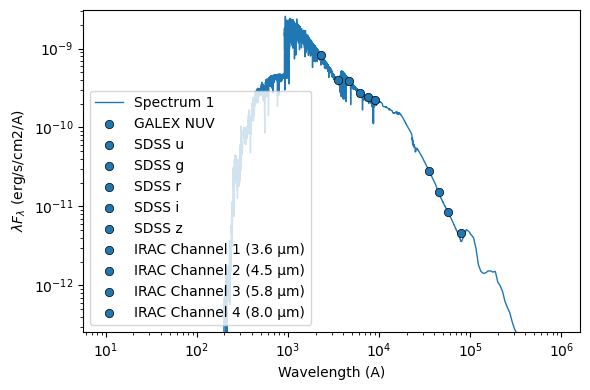

In [11]:
specs[0].plot(per_wavelength=True,phot_points=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z',
                                                     'spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4'])

In [348]:
#for s in spec:
#    s.plot(show_spectral_lines=False,log=True,per_wavelength=True,bands=['sdss_u','sdss_r'],)

In [132]:
#spec[0].plot(show_spectral_lines=False,zoom_on_line=['Ha','Hb'],spectra=[spec[0],spec[2],spec[-1]],log=True,ymin=3e-15,ymax=8e-14)  

In [133]:
#spec[0].plot(show_spectral_lines=False,spectra=[spec[0],spec[2],spec[-1]],log=True,per_wavelength=True) 

In [134]:
#spec[2].plot(show_spectral_lines=True,spectra=[spec_models[0],spec_models[10],spec_models[-1]],log=True)

In [49]:
fitter = PFitter(specs,
                 model_pars=['age','tau_main'],
                )

Loading nebular lines templates from  nebular_Byler_mist_2018.lines
 Emission line metallicity requested 0.0017, found 0.0020
Tabulated values for ionized gas age (Myr): [ 0.5  1.   2.   3.   4.   5.   6.   7.  10. ]
Tabulated values for ionization coefficient: [-4.  -3.5 -3.  -2.5 -2.  -1.5 -1. ]
Loading of nebular lines templates completed.
Tabulated alpha values from 'alpha_dh02.dat': [0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625
 0.6875 0.75   0.8125 0.875  0.9375 1.     1.0625 1.125  1.1875 1.25
 1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875 1.75   1.8125 1.875
 1.9375 2.     2.0625 2.125  2.1875 2.25   2.3125 2.375  2.4375 2.5
 2.5625 2.625  2.6875 2.75   2.8125 2.875  2.9375 3.     3.0625 3.125
 3.1875 3.25   3.3125 3.375  3.4375 3.5    3.5625 3.625  3.6875 3.75
 3.8125 3.875  3.9375 4.    ]
Loading of dust emission templates completed.


Time per synth: 0.004007816314697266 s


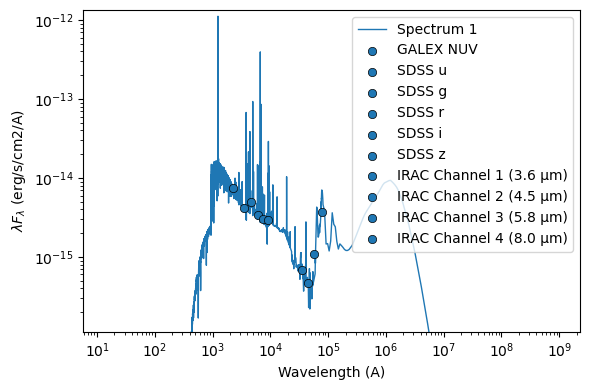

Time per synth: 0.003538846969604492 s


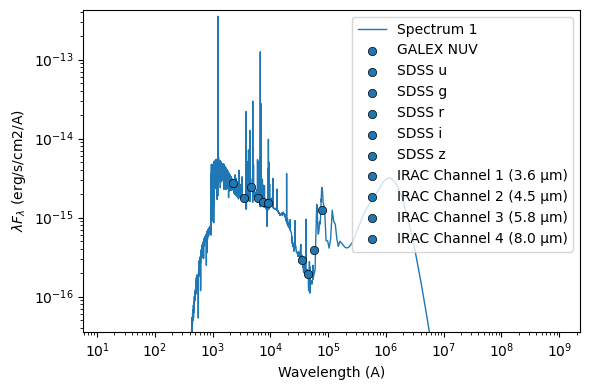

Time per synth: 0.0038118362426757812 s


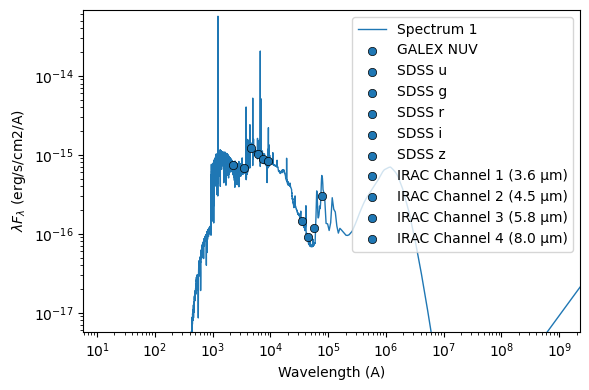

Time per synth: 0.003457784652709961 s


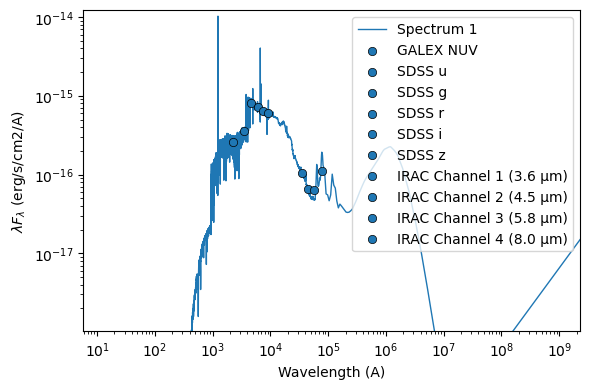

Time per synth: 0.0036101341247558594 s


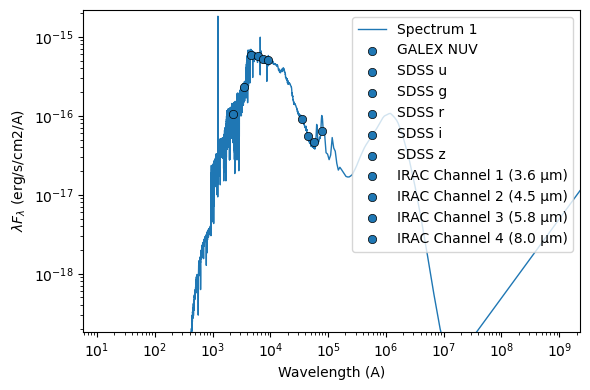

Time per synth: 0.003693819046020508 s


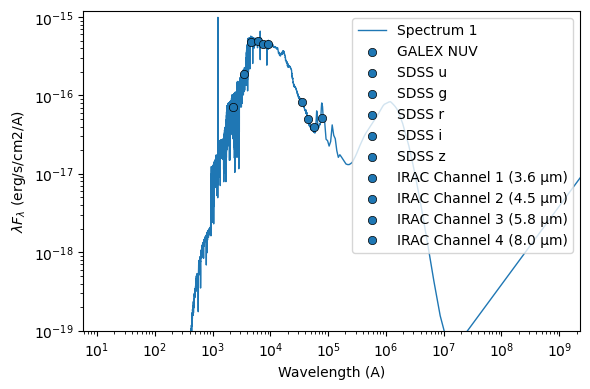

Time per synth: 0.0036978721618652344 s


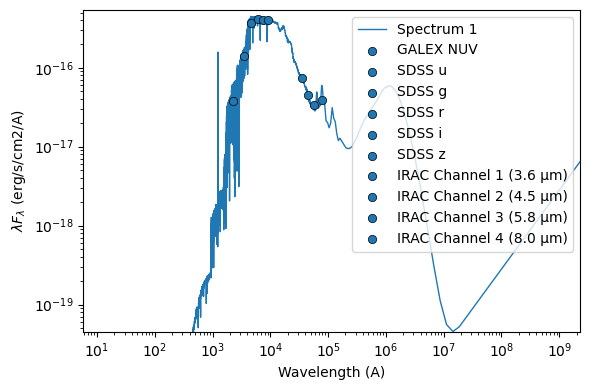

In [27]:


for age in np.linspace(100,1000,7):
    total_spec = fitter.synthetic_spectrum(
            metal=0.017,
            multi_component=True,
            age=age,
            tau_main=100,
            fesc=-0.004,
            av=0.2,
            av_ext= 0.094,
            alpha=2.35,
            m_star=9.2,
            ion_gas=-3.94,
            age_gas=3.997,
            redshift=0.02,
            dl=104,  # Luminosity distance in Mpc (assumed)
        )

       
    total_spec.plot(per_wavelength=True,phot_points=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z',
                                                     'spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4'],)

    

In [33]:
mock_spec = fitter.synthetic_spectrum(
            metal=0.017,
            multi_component=True,
            age=102,
            tau_main=100,
            fesc=-0.004,
            av=0.2,
            av_ext= 0.094,
            alpha=2.35,
            m_star=9.2,
            ion_gas=-3.94,
            age_gas=13,
            redshift=0.02,
            dl=104,  # Luminosity distance in Mpc (assumed)
        )



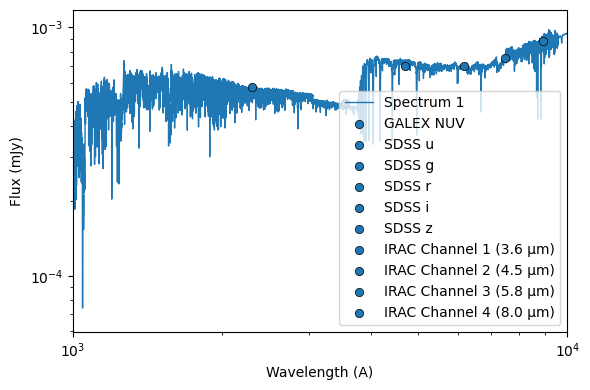

In [34]:
bands=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z','spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4']
mock_spec.plot(per_wavelength=False,phot_points=bands,y_units='mJy',x_units='A',
              winf=1000,wsup=1e4) #,ymin=1e-7,ymax=1e-4

phot_points = mock_spec.get_phot(bands=bands,units='mJy')

for b in bands: 
    value, error = phot_points.data[b]
    phot_points.data[b] = (value, 0.1 * value)




In [73]:
phot_points.print

,Value,Error,SNR
Band,,,
galex_nuv,0.000574,0.000057,10.0
sdss_u,0.000495,0.000049,10.0
sdss_g,0.000701,0.000070,10.0
sdss_r,0.000698,0.000070,10.0
sdss_i,0.000751,0.000075,10.0
sdss_z,0.000880,0.000088,10.0
spitzer_irac_1,0.000702,0.000070,10.0
spitzer_irac_2,0.000618,0.000062,10.0
spitzer_irac_3,0.001882,0.000188,10.0


In [50]:

results = fitter.run_fit(phot=phot_points, 
                         bands=bands, 
                         fix_pars={'ion_gas':-3.94,'age_gas':13,'fesc':-0.004,'m_star':9.2,},
                        nlive=100,
                        dlogz=0.1)

                         #fix_pars={'ion_gas':-3.94,'age_gas':13,'fesc':-0.004,'av':0.2,'av_ext':0.094, 'trunctau':8.202,
                         #          'alpha':2.35,'m_star':9.2,},)


Using the following photometric filters: galex_nuv, sdss_u, sdss_g, sdss_r, sdss_i, sdss_z, spitzer_irac_1, spitzer_irac_2, spitzer_irac_3, spitzer_irac_4
Redshift not provided and not found in phot dictionary or spectrum header.
Redshift set to 0.
Initializing live points
Running dynesty


1148it [02:42,  7.05it/s, +100 | bound: 284 | nc: 1 | ncall: 45893 | eff(%):  2.725 | loglstar:   -inf < 81.545 <    inf | logz: 74.734 +/-  0.226 | dlogz:  0.000 >  0.010]


In [431]:
# Traceplot: evolution of parameters during sampling
#fig, axes = dyplot.traceplot(results)
#plt.show()

# Runplot: evidence and log-likelihood evolution
#fig, axes = dyplot.runplot(results)
#plt.show()


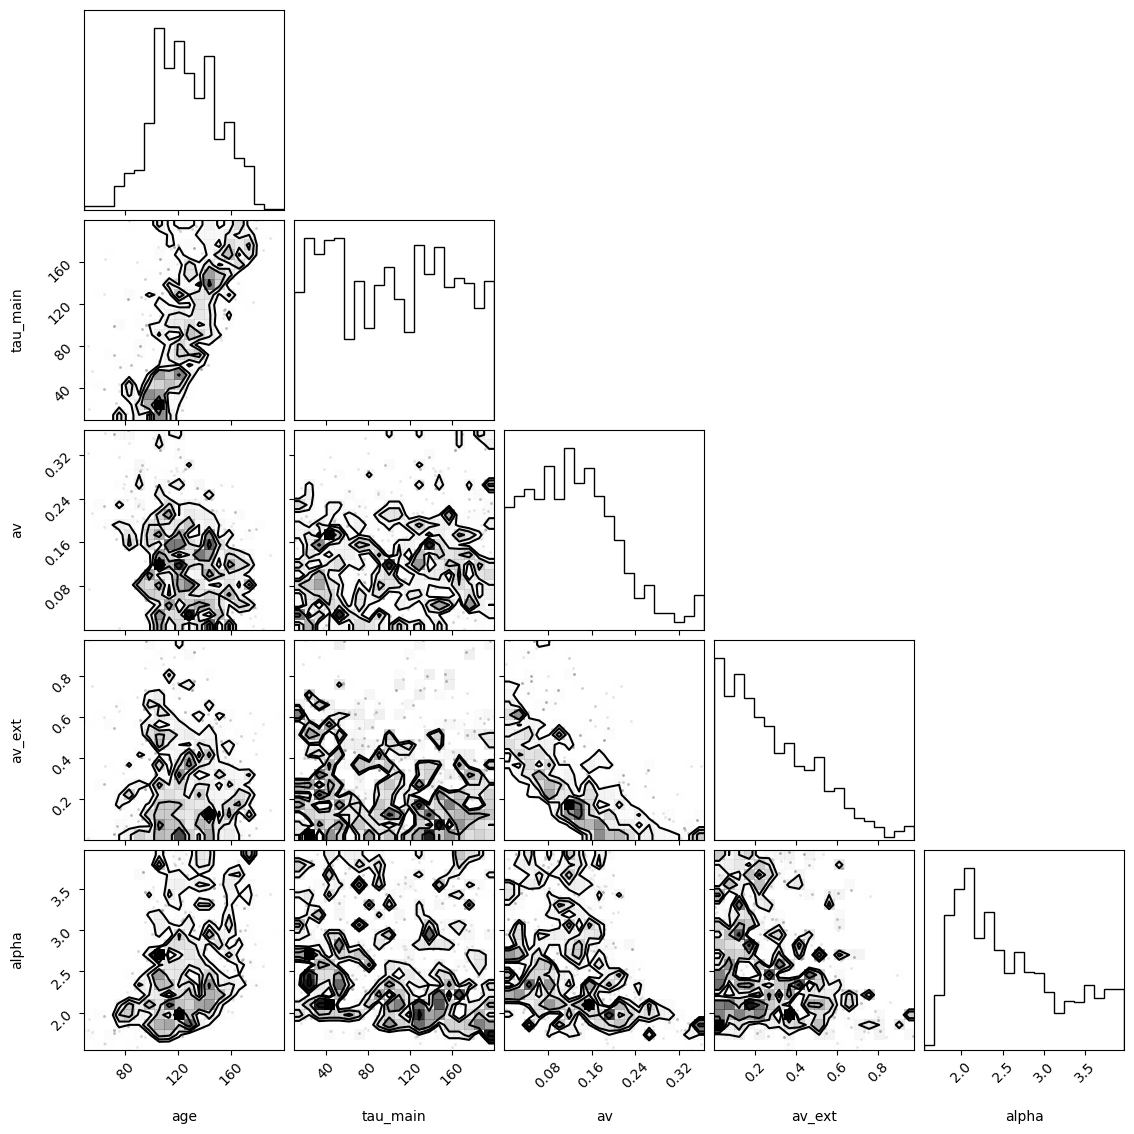

In [51]:
fitter.cornerplot(results)

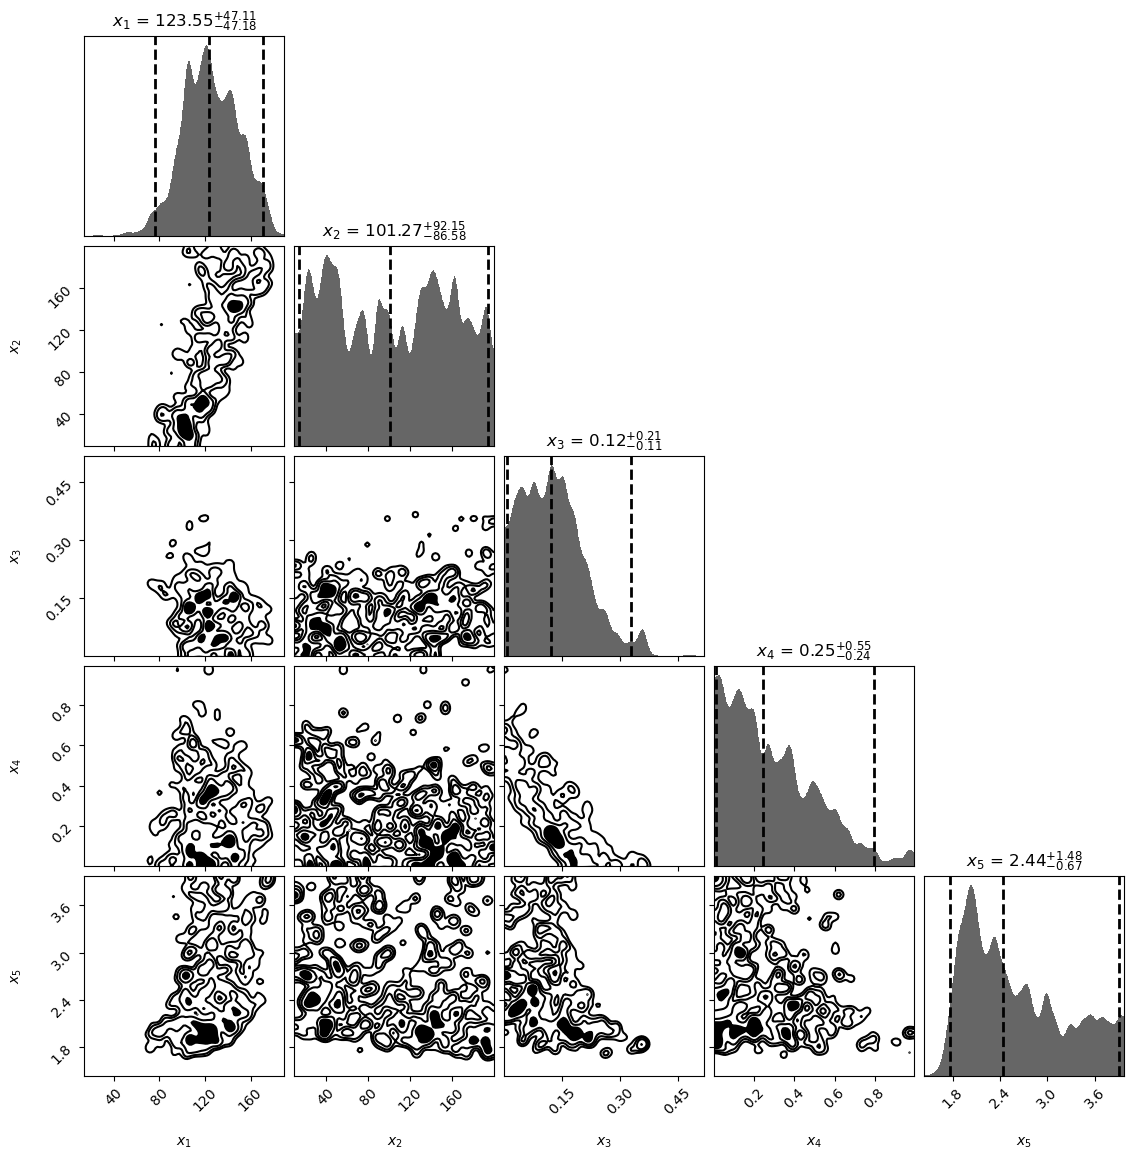

In [52]:
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

fig, axes = dyplot.cornerplot(results, 
                              show_titles=True, 
                              title_fmt=".2f")
plt.show()

In [430]:
best_fit = equal_samples.mean(axis=0)
print("Best-fit parameters:", best_fit)

# Or MAP-like point
max_logl_idx = np.argmax(results.logl)
print("Maximum likelihood parameters:", results.samples[max_logl_idx])

Best-fit parameters: [119.81380835  85.92098099]
Maximum likelihood parameters: [104.29331071  47.54977691]
